In [24]:
%matplotlib inline
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

import os
import cv2
import numpy as np
import torch
from torch.autograd import Variable
import quat_math
import pickle

from PIL import Image
import scipy.io as scio
from functools import partial
from object_pose_utils.utils import to_np, to_var

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
from quat_math import quat2AxisAngle

def quats2Point(quats):
    pts = []
    for q in quats:
        xi, theta = quat2AxisAngle(q)
        pts.append(xi*theta)
    return np.array(pts)

def scatterSO3(vertices, vals, q_gt = None, alpha_max = 1.0):
    #c = cmap(vals)
    a = np.maximum(0,np.minimum(1, (vals - min(vals))/(max(vals) - min(vals))))
    c = cmap(a)
    
    c[:,3] = alpha_max*a

    pts = quats2Point(vertices)
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=a*10, c=c)

    if(q_gt is not None):
        pt_gt = quats2Point(q_gt)
        ax.scatter(pt_gt[:,0], pt_gt[:,1], pt_gt[:,2], c='r', marker='x')

In [4]:
from transforms3d.quaternions import quat2mat, mat2quat

def getPoseCNNQuat(data, obj):
    pose_idx = np.where(data['rois'][:,1].flatten()==obj)[0]
    if(len(pose_idx) == 0):
        return None
    else:
        pose_idx = pose_idx[0]
    pose = data['poses'][pose_idx]
    q = pose[:4][[1,2,3,0]]
    q /= np.linalg.norm(q)
    t = pose[4:7]
    return q


In [5]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.feature_dataset import FeatureDataset

from object_pose_utils.datasets.image_processing import ImageNormalizer
from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'
object_list = list(range(1,22))
mode = "test"

output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, 
                 otypes.IMAGE_CROPPED, 
                 otypes.DEPTH_POINTS_MASKED_AND_INDEXES]



In [37]:
test_feature_root = '/scratch/bokorn/results/dense_fusion_local_feat_test/'
feature_root = '/scratch/bokorn/results/dense_fusion_local_orig_feat/'
feature_key = 'feat_global'

#comp_model_checkpoint = '/scratch/bokorn/results/multi_object/df_local_global/trainval_lr_1e-5_top_x2000/2019-07-03_11-34-46/all/weights/checkpoint_31000.pth'
comp_model_checkpoint = '/scratch/bokorn/results/multi_object/df_local_global/trainval_lr_1e-5_top_x500/2019-07-04_04-50-15/all/weights/checkpoint_106000.pth'
feature_size = 1024

sigmas_data = np.load('/home/bokorn/src/DenseFusion/df_orig_sigmas.npz', allow_pickle=True)
sigmas_single = sigmas_data['single_sigma'].item()
sigmas_mixture = sigmas_data['mixture_sigma'].item()

from se3_distributions.models.compare_networks import SigmoidCompareNet

estimator_comp = SigmoidCompareNet(feature_size, 21)
estimator_comp.load_state_dict(torch.load(comp_model_checkpoint))
estimator_comp.cuda();

from object_pose_utils.utils.interpolation import BinghamInterpolation, TetraInterpolation
from object_pose_utils.utils.bingham import isobingham_likelihood
tetra_interp = TetraInterpolation(2)

In [38]:
from se3_distributions.datasets.ycb_dataset import getYCBSymmeties
from object_pose_utils.utils.pose_processing import symmetricAngularDistance, meanShift
import pathlib


import scipy.io as scio
from tqdm import tqdm_notebook as tqdm

grid_size = 3885
rep_indices = np.repeat(np.arange(1), grid_size)

err_compare = {}
err_bing = {}
err_bmm = {}

lik_compare = {}
lik_bing = {}
lik_bmm = {}

err_compare_max_shift = {}


with torch.no_grad():
    for object_id in tqdm(object_list):
        sym_axis, sym_ang = getYCBSymmeties(object_id)
        ycb_dataset = FeatureDataset(dataset_root = dataset_root,
                                     feature_root = test_feature_root,
                                     feature_key = feature_key,
                                     resample_on_error = False,
                                     mode=mode, object_list = [object_id])
        grid_vertices = torch.load(os.path.join(feature_root, 'grid',
            '{}_vertices.pt'.format(ycb_dataset.classes[object_id])))
        grid_features = torch.load(os.path.join(feature_root, 'grid',
            '{}_{}_features.pt'.format(feature_key,ycb_dataset.classes[object_id])))

        grid_size = grid_vertices.shape[0]
        grid_features = to_var(grid_features)
        rep_indices = np.repeat(np.arange(1), grid_size)
        
        lik_compare[object_id] = []
        err_compare[object_id] = []
        lik_bing[object_id] = []
        err_bing[object_id] = []
        lik_bmm[object_id] = []
        err_bmm[object_id] = []
        
        err_compare_max_shift[object_id] = []

        pathlib.Path('results/data'.format(ycb_dataset.classes[object_id])).mkdir(parents=True, exist_ok=True)
        
        for j, data in tqdm(enumerate(ycb_dataset), total=len(ycb_dataset)):
            obj, feat, quat = data
            if(len(obj) == 0):
                lik_compare[object_id].append(np.nan)
                err_compare[object_id].append(np.nan)
                lik_bing[object_id].append(np.nan)
                err_bing[object_id].append(np.nan)
                lik_bmm[object_id].append(np.nan)
                err_bmm[object_id].append(np.nan)
                err_compare_max_shift[object_id].append(np.nan)
                continue
            feature_data = np.load('{}/data/{}_{}_feat.npz'.format(ycb_dataset.feature_root, 
                ycb_dataset.getPath(j), ycb_dataset.classes[obj]))
            df_quat = torch.tensor(feature_data['max_q']).float()
            df_quat_all = torch.tensor(feature_data['pred_q']).float()
            
            idx = torch.autograd.Variable(obj - 1).unsqueeze(0).cuda()
            feat = to_var(feat).unsqueeze(0)

            dist_est = estimator_comp(grid_features, feat[rep_indices])
            dist_est = torch.gather(dist_est, 1, idx[rep_indices])
            #dist_est = torch.log(dist_est)*np.pi/9.0
            #dist_est = torch.exp(dist_est/comp_sigmas[obj.item()])
                
            tetra_interp.setValues(to_np(dist_est.flatten()))
            lik_compare[object_id].append(tetra_interp.smooth(to_np(quat)).item())
            
            
            lik_bing[object_id].append(isobingham_likelihood(df_quat.cuda(), 
                                torch.tensor(sigmas_single[obj.item()]).unsqueeze(0).float().cuda(),
                                quat.unsqueeze(0).cuda()).item()*2)
            
            bingham_mixture = BinghamInterpolation(df_quat_all, torch.ones(df_quat_all.shape[0]), 
                                   sigma=sigmas_mixture[obj.item()])
            
            
            lik_bmm[object_id].append(bingham_mixture(quat.unsqueeze(0).cuda()).item())
            bmm_quat = grid_vertices[torch.argmax(bingham_mixture(grid_vertices.cuda()))].unsqueeze(0)
            
            mode_quat = grid_vertices[torch.argmax(dist_est)].unsqueeze(0)
            
            #v_shift = meanShift(mode_quat.cuda(), grid_vertices.cuda(), dist_est.cuda(),
            #                    sigma=np.pi/9, max_iter = 100)
            
            v_shift = meanShift(mode_quat.cuda(), grid_vertices.cuda(), dist_est.cuda(),
                                sigma=np.pi/9, max_iter = 100)
            
            err_compare_max_shift[object_id].append(symmetricAngularDistance(v_shift.cpu(), quat.unsqueeze(0),
                                                 sym_axis, sym_ang).item()*180/np.pi)
            
            
            err_compare[object_id].append(symmetricAngularDistance(mode_quat, quat.unsqueeze(0),
                                             sym_axis, sym_ang).item()*180/np.pi)
            
            err_bing[object_id].append(symmetricAngularDistance(df_quat.unsqueeze(0), quat.unsqueeze(0),
                                           sym_axis, sym_ang).item()*180/np.pi)
   
            err_bmm[object_id].append(symmetricAngularDistance(bmm_quat, quat.unsqueeze(0),
                                           sym_axis, sym_ang).item()*180/np.pi)

            savepath = 'results/{}'.format(ycb_dataset.getPath(j))
            pathlib.Path(savepath).mkdir(parents=True, exist_ok=True)
            
            scio.savemat('{}/{}_{}_500_results.mat'.format(savepath, 
                                                    ycb_dataset.classes[object_id], 
                                                    ycb_dataset.feature_key),
                        {'index':j,
                         'quat':to_np(quat),
                         'mode_quat':to_np(mode_quat),
                         'dist_est':to_np(dist_est),
                         'comp_err':err_compare[object_id][-1],
                         'comp_lik':lik_compare[object_id][-1],
                         'df_single_quat':to_np(df_quat),
                         'df_single_err':err_bing[object_id][-1],
                         'df_single_lik':lik_bing[object_id][-1],
                         'df_bmm_quat':to_np(bmm_quat),
                         'df_bmm_err':err_bmm[object_id][-1],
                         'df_bmm_lik':lik_bmm[object_id][-1],
                         'sigma_single':sigmas_single[obj.item()],
                         'sigma_mixture':sigmas_mixture[obj.item()],
                         })
            
np.savez('results/df_bing_comp_500.npz', 
         err_compare=err_compare,
         lik_compare=lik_compare,
         err_bing=err_bing,
         lik_bing=lik_bing,
         err_bmm=err_bmm,
         lik_bmm=lik_bmm)

Exception on index 49: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_rot_trained_local_feat/data/0050/000633_005_tomato_soup_can_feat.npz'
Exception on index 50: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_rot_trained_local_feat/data/0050/000640_005_tomato_soup_can_feat.npz'
Exception on index 51: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_rot_trained_local_feat/data/0050/000642_005_tomato_soup_can_feat.npz'
Exception on index 52: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_rot_trained_local_feat/data/0050/000644_005_tomato_soup_can_feat.npz'
Exception on index 54: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_rot_trained_local_feat/data/0050/000653_005_tomato_soup_can_feat.npz'
Exception on index 55: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_rot_trained_local_feat/data/0050/000660_005_tomato_soup_can_fe

Exception on index 87: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_rot_trained_local_feat/data/0049/000833_010_potted_meat_can_feat.npz'
Exception on index 108: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_rot_trained_local_feat/data/0049/001157_010_potted_meat_can_feat.npz'
Exception on index 111: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_rot_trained_local_feat/data/0049/001179_010_potted_meat_can_feat.npz'
Exception on index 115: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_rot_trained_local_feat/data/0049/001222_010_potted_meat_can_feat.npz'
Exception on index 116: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_rot_trained_local_feat/data/0049/001229_010_potted_meat_can_feat.npz'
Exception on index 118: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_rot_trained_local_feat/data/0049/001247_010_potted_meat_c

In [40]:
isobingham_likelihood(df_quat.cuda(), 
                                torch.tensor(sigmas_single[obj.item()]).unsqueeze(0).float().cuda(),
                                grid_vertices.cuda()).shape

torch.Size([3885, 1])

In [21]:
ls results

0048/                      hist_filter__fc6_reg_results_2x1.npz
0049/                      hist_filter__fc6_reg_results_3x4.npz
0050/                      hist_filter__fc6_reg_results_4x1.npz
0051/                      hist_filter__fc6_results_10x1.npz
0052/                      hist_filter__fc6_results_10x4.npz
0053/                      hist_filter__fc6_results_2x1.npz
0054/                      hist_filter__fc6_results_3x1.npz
0055/                      hist_filter__fc6_results_3x20.npz
0056/                      hist_filter__fc6_results_3x4.npz
0057/                      hist_filter__fc6_results_4x1.npz
0058/                      hist_filter__feat_global_reg_results_10x1.npz
0059/                      hist_filter__feat_global_reg_results_10x4.npz
data/                      hist_filter__feat_global_reg_results_2x1.npz
df_bing_comp.npz           hist_filter__feat_global_reg_results_3x4.npz
df_bing_comp_ROT.npz       hist_filter__feat_global_reg_results_4x1.npz
df_bingreg.npz         

In [128]:
from se3_distributions.datasets.ycb_dataset import getYCBSymmeties
from object_pose_utils.utils.pose_processing import symmetricAngularDistance, meanShift, unique_tol
import pathlib


import scipy.io as scio
from tqdm import tqdm_notebook as tqdm

grid_size = 3885
rep_indices = np.repeat(np.arange(1), grid_size)

lik_compare = {}
err_compare = {}
err_compare_max_shift = {}

comp_sigmas_data = np.load('/home/bokorn/src/se3_distributions/se3_distributions/notebooks/{}_sigma.npz'.format(feature_key), allow_pickle=True)
comp_sigmas = comp_sigmas_data['sigmas'].item()

with torch.no_grad():
    for object_id in tqdm(object_list):
        sym_axis, sym_ang = getYCBSymmeties(object_id)
        ycb_dataset = FeatureDataset(dataset_root = dataset_root,
                                     feature_root = test_feature_root,
                                     feature_key = feature_key,
                                     resample_on_error = False,
                                     mode=mode, object_list = [object_id])
        grid_vertices = torch.load(os.path.join(feature_root, 'grid',
            '{}_vertices.pt'.format(ycb_dataset.classes[object_id])))
        grid_features = torch.load(os.path.join(feature_root, 'grid',
            '{}_{}_features.pt'.format(feature_key,ycb_dataset.classes[object_id])))

        grid_size = grid_vertices.shape[0]
        grid_features = to_var(grid_features)
        rep_indices = np.repeat(np.arange(1), grid_size)
        
        lik_compare[object_id] = []
        err_compare[object_id] = []
        err_compare_max_shift[object_id] = []
        
        pathlib.Path('results/data'.format(ycb_dataset.classes[object_id])).mkdir(parents=True, exist_ok=True)
        
        for j, data in tqdm(enumerate(ycb_dataset), total=len(ycb_dataset)):
            obj, feat, quat = data
            if(len(obj) == 0):
                lik_compare[object_id].append(np.nan)
                err_compare[object_id].append(np.nan)
                err_compare_max_shift[object_id].append(np.nan)
                continue
            
            feature_data = np.load('{}/data/{}_{}_feat.npz'.format(ycb_dataset.feature_root, 
                ycb_dataset.getPath(j), ycb_dataset.classes[obj]))

            idx = torch.autograd.Variable(obj - 1).unsqueeze(0).cuda()
            feat = to_var(feat).unsqueeze(0)

            dist_est = estimator_comp(grid_features, feat[rep_indices])
            dist_est = torch.gather(dist_est, 1, idx[rep_indices])
            dist_est = torch.log(dist_est)*np.pi/9.0
            dist_est = torch.exp(dist_est/comp_sigmas[obj.item()])
            
            tetra_interp.setValues(to_np(dist_est.flatten()))
            lik_compare[object_id].append(tetra_interp.smooth(to_np(quat)).item())
            
            mode_quat = grid_vertices[torch.argmax(dist_est)].unsqueeze(0)
            
            v_shift = meanShift(mode_quat.cuda(), grid_vertices.cuda(), dist_est.cuda(),
                                sigma=np.pi/9, max_iter = 100)
            
            err_compare[object_id].append(symmetricAngularDistance(mode_quat, quat.unsqueeze(0),
                                             sym_axis, sym_ang).item()*180/np.pi)
            
            err_compare_max_shift[object_id].append(symmetricAngularDistance(v_shift.cpu(), quat.unsqueeze(0),
                                                 sym_axis, sym_ang).item()*180/np.pi)
            
            #v_shift_all = meanShift(grid_vertices.cuda(), grid_vertices.cuda(), dist_est.cuda(),
            #                    sigma=np.pi/9, max_iter = 100)            
            #v_shift_all = unique_tol(v_shift_all)
            #tetra_interp.setValues(to_np(dist_est.flatten()))            
            #err_compare_all_shift[object_id].append(symmetricAngularDistance(
            #    v_shift_all[np.argmax(tetra_interp.smooth(to_np(v_shift_all)))].cpu(),
            #    quat.unsqueeze(0),sym_axis, sym_ang).item()*180/np.pi)
            #
            #err_bing[object_id].append(symmetricAngularDistance(est_quat.unsqueeze(0), quat.unsqueeze(0),
            #                               sym_axis, sym_ang).item()*180/np.pi)
            savepath = 'results/{}'.format(ycb_dataset.getPath(j))
            pathlib.Path(savepath).mkdir(parents=True, exist_ok=True)
            
            scio.savemat('{}/{}_{}_sigma_results.mat'.format(savepath, 
                                                    ycb_dataset.classes[object_id], 
                                                    ycb_dataset.feature_key),
                        {'index':j,
                         'quat':to_np(quat),
                         'mode_quat':to_np(mode_quat),
                         'dist_est':to_np(dist_est),
                         'comp_err':err_compare[object_id][-1],
                         'comp_lik':lik_compare[object_id][-1],
                         'sigma_comp':comp_sigmas[obj.item()],
                         })
np.savez('results/local_global_comp_sigma_mean_shift.npz', 
         lik_compare=lik_compare,
         err_compare=err_compare,
         err_compare_max_shift=err_compare_max_shift)

Exception on index 49: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_test/data/0050/000633_005_tomato_soup_can_feat.npz'
Exception on index 50: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_test/data/0050/000640_005_tomato_soup_can_feat.npz'
Exception on index 51: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_test/data/0050/000642_005_tomato_soup_can_feat.npz'
Exception on index 52: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_test/data/0050/000644_005_tomato_soup_can_feat.npz'
Exception on index 54: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_test/data/0050/000653_005_tomato_soup_can_feat.npz'
Exception on index 55: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_test/data/0050/000660_005_tomato_soup_can_feat.npz'
Exception on index 57: [Errno 2] N

Exception on index 87: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_test/data/0049/000833_010_potted_meat_can_feat.npz'
Exception on index 108: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_test/data/0049/001157_010_potted_meat_can_feat.npz'
Exception on index 111: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_test/data/0049/001179_010_potted_meat_can_feat.npz'
Exception on index 115: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_test/data/0049/001222_010_potted_meat_can_feat.npz'
Exception on index 116: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_test/data/0049/001229_010_potted_meat_can_feat.npz'
Exception on index 118: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_test/data/0049/001247_010_potted_meat_can_feat.npz'
Exception on index 129: [Errn

In [129]:
np.mean(np.array(err_compare[object_id]) - np.array(err_compare_max_shift[object_id]))

0.013277318564073801

In [139]:
for obj in range(1,22):
    print(obj, np.nanmean(np.log(lik_compare[obj])), np.nanmean(err_compare[obj]), np.nanmean(err_compare_max_shift[obj]))

1 -1.6347311007039915 105.35854762878145 105.18742676812332
2 -inf 44.779595072655674 15.799745458655103
3 -1.0256672796575768 29.63639409204604 29.10533500889512
4 1.0065429698496298 37.9240135987211 33.16825419876589
5 -inf 49.365964524318265 40.18348041834227
6 -0.4216652890682759 69.238155502508 69.9490643029662
7 -inf 90.25202082169587 90.02065295107744
8 -inf 49.89328129606242 30.284530906915197
9 -0.2701879665875446 52.876655405518036 47.98782371750556
10 -1.4834144232105895 106.81388405125887 106.77394943885966
11 -8.70433937340117 30.927437931227406 28.10183058586574
12 1.0920741419584277 62.4861707426393 60.64105166954278
13 -3.1189088248169154 101.97602086687671 102.25496299757536
14 -8.291519371418461 114.48439816928958 114.45086331643651
15 -inf 52.64294090411299 52.284043861272515
16 -7.490059049307779 48.418394328223926 47.93828541512086
17 -inf 121.26180297006226 121.1668757556943
18 -inf 98.16204183522477 98.19376861597374
19 -inf 98.15587925404064 98.07625511237995
20

/home/bokorn/src/se3_distributions/bpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


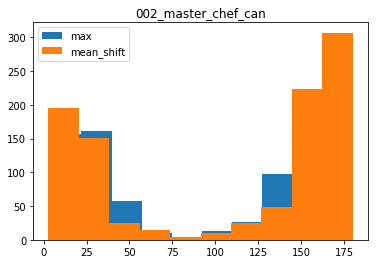

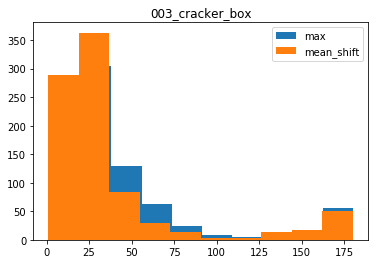

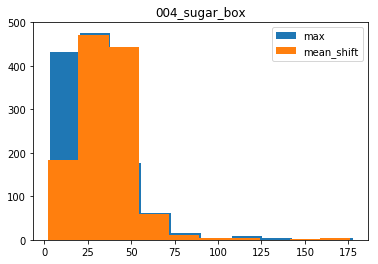

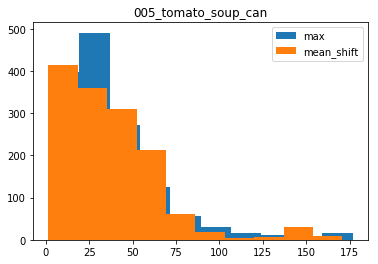

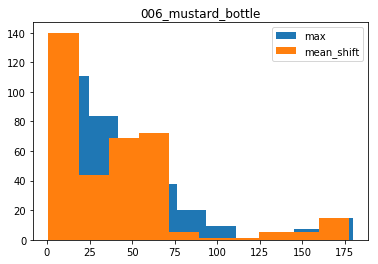

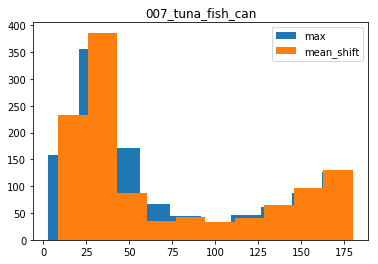

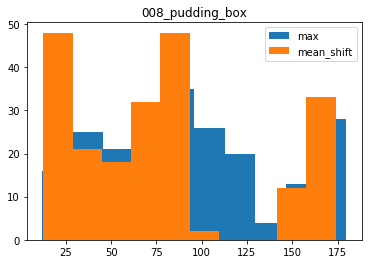

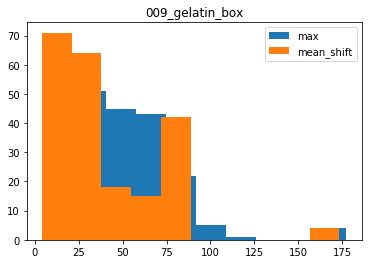

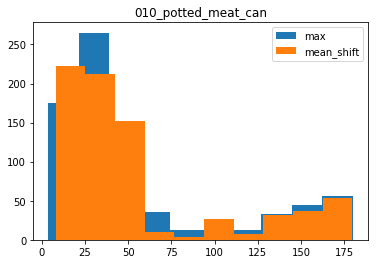

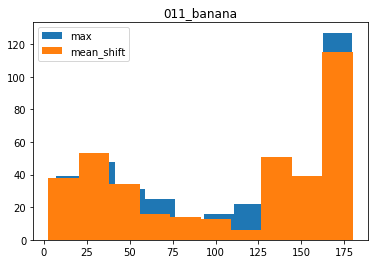

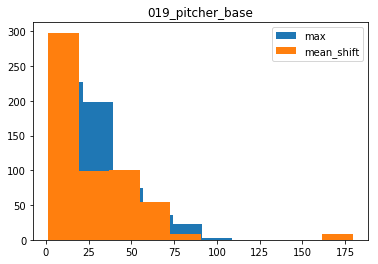

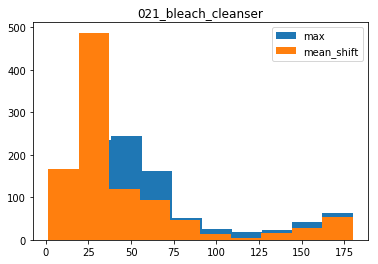

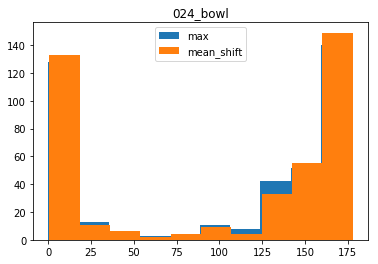

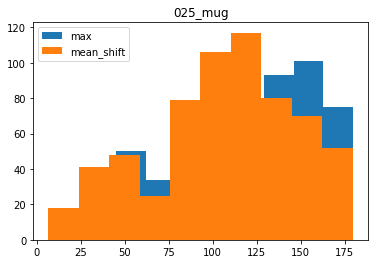

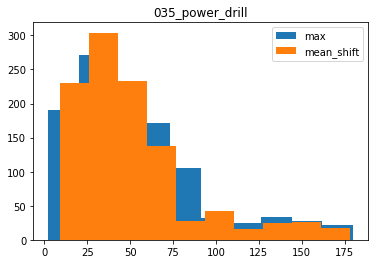

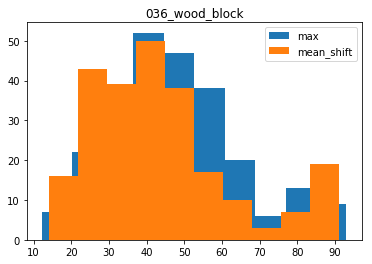

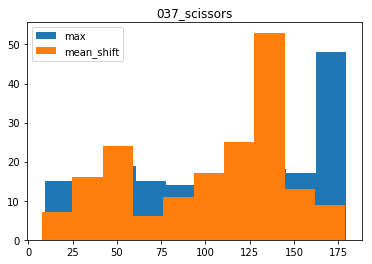

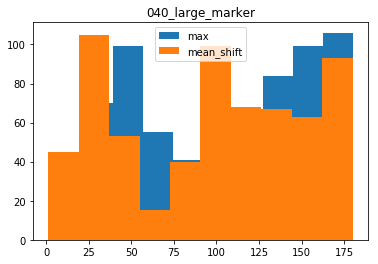

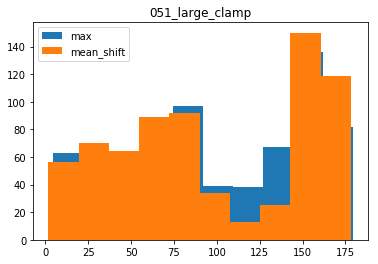

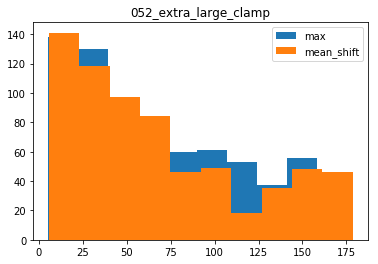

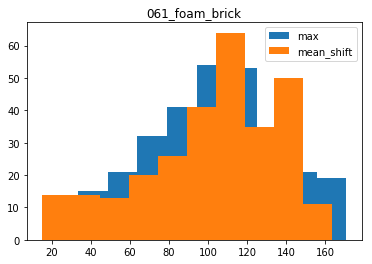

In [116]:
for obj in range(1,22):
    plt.hist(err_compare[obj], label='max')
    plt.hist(err_compare_max_shift[obj], label='mean_shift')
    plt.title(ycb_dataset.classes[obj])
    plt.legend()
    plt.show()

In [111]:
bing_interp(quat.unsqueeze(0).cuda())

tensor([0.0854], device='cuda:0')

In [35]:
dataset_root

'/ssd0/datasets/ycb/YCB_Video_Dataset'

In [107]:
sigma = torch.tensor(sigmas[obj.item()]).unsqueeze(0).float()
torch.cat([torch.zeros(1).float(),-sigma, -sigma, -sigma])

tensor([ 0.0000, -0.6633, -0.6633, -0.6633])

In [79]:
tetra_interp.setValues(to_np(dist_est.flatten()))
lik = tetra_interp.smooth(to_np(quat))
print(lik)

[0.13604579]


In [68]:
print(pcnn_quat)
print(quat)

[-0.5019051   0.09629406 -0.03618243 -0.8587838 ]
tensor([-0.1788, -0.3948, -0.8702,  0.2345])


[0.02727548]
[0.08283998]


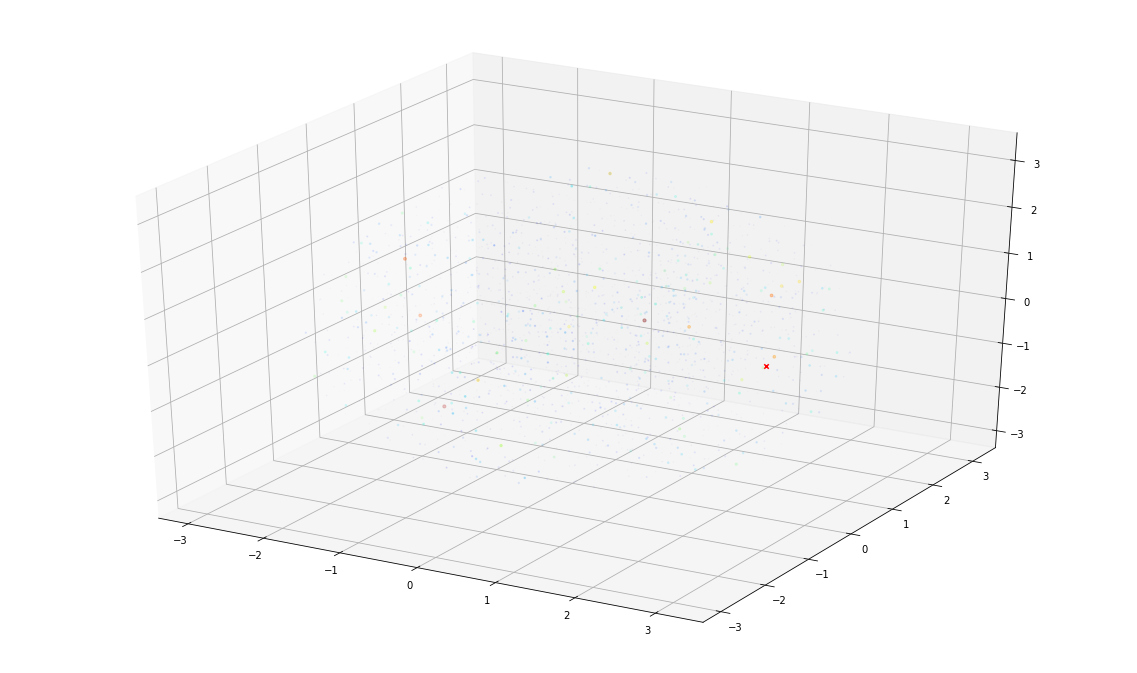

In [37]:
from mpl_toolkits.mplot3d import Axes3D
cmap = plt.get_cmap('jet')
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

sigmas = np.load('../notebooks/feat_global_sigma.npz')['sigmas']
scatterSO3(to_np(grid_vertices), to_np(torch.exp(torch.log(dist_est.flatten())*np.pi/9/sigmas[object_id])),
           [to_np(quat)], alpha_max = .5)
tetra_interp.setValues(to_np(torch.exp(torch.log(dist_est.flatten())*np.pi/9/sigmas[object_id])))
print(tetra_interp.smooth(to_np(quat)))
tetra_interp.setValues(to_np(dist_est.flatten()))
print(tetra_interp.smooth(to_np(quat)))

In [22]:
to_np(quat)
#quats2Point(to_np(quat)[0])
#to_np(dist_est)

array([ 0.30252334,  0.4792338 ,  0.6599504 , -0.49323422], dtype=float32)

In [99]:
import torch

def bingham_multiply(M1, Z1, M2, Z2):
    A = torch.mm(torch.mm(M1,Z1),M1.t()) + torch.mm(torch.mm(M2,Z2),M2.t())
    e_vals, e_vecs = torch.eig(A, eigenvectors=True)
    assert(torch.all(e_vals[:,1] == 0)) 
    e_vals = e_vals[:,0]
    idxs = torch.argsort(e_vals, descending=True)
    Z = e_vals[idxs] - torch.max(e_vals)
    M = e_vecs[idxs].t()
    return M, Z




In [43]:
M1 = torch.tensor([[   0.4497,    0.5806,    0.5411,    0.4098],
    [-0.5806,    0.4497,    0.4098,   -0.5411],
    [-0.5411,   -0.4098,    0.4497,    0.5806],
    [-0.4098,    0.5411,   -0.5806,    0.4497]])
Z1 = torch.diag(torch.tensor([0,   -0.3922,   -0.6555,   -0.1712]))

M2 = torch.tensor([[    -0.3252,   -0.5904,    0.7374,    0.0440],
   [0.5904,   -0.3252,    0.0440,   -0.7374],
   [-0.7374,   -0.0440,   -0.3252,   -0.5904],
   [-0.0440,    0.7374,    0.5904,   -0.3252]])

Z2 = torch.diag(torch.tensor([0, -0.0971,   -0.8235,   -0.6948]))

In [62]:
M2

tensor([[-0.3252, -0.5904,  0.7374,  0.0440],
        [ 0.5904, -0.3252,  0.0440, -0.7374],
        [-0.7374, -0.0440, -0.3252, -0.5904],
        [-0.0440,  0.7374,  0.5904, -0.3252]])

In [95]:
from object_pose_utils.utils.bingham import bingham_likelihood
q = torch.tensor([0,0,0,1]).float()
M,Z = bingham_multiply(M1, Z1, M2, Z2)
print(M,Z)
torch.det(M)
q_test = torch.tensor([[-0.1468,    0.6887,   -0.6850,   -0.5118]])
bingham_likelihood(M.unsqueeze(0).cuda(), Z.cuda(), q.unsqueeze(0).cuda())
bingham_likelihood(M.unsqueeze(0).cuda(), Z.cuda(), q_test.cuda())


tensor([[-0.2483,  0.6323, -0.2450, -0.6917],
        [ 0.6295, -0.2734, -0.6894, -0.2318],
        [-0.6897, -0.2192, -0.6343,  0.2719],
        [-0.2576, -0.6909,  0.2498, -0.6276]]) tensor([ 0.0000, -0.2946, -0.7540, -0.9864])


tensor([[0.0795]], device='cuda:0')

In [100]:
from object_pose_utils.utils import to_np
M, Z = bingham_multiply_np(to_np(M1), to_np(Z1), to_np(M2), to_np(Z2))
bingham_likelihood(torch.tensor(M).unsqueeze(0).cuda(), torch.tensor(Z).cuda(), q_test.cuda())

tensor([[0.0704]], device='cuda:0')